In [2]:
import os
import sys
import glob
import datetime

import gzip
import pickle

import numpy as np
import pandas as pd
import scipy 


import matplotlib.pyplot as plt
import seaborn as sns

import biosppy
from biosppy.signals import ecg
from scipy import signal
import pyhrv
import pyhrv.tools as tools
import pyhrv.time_domain as td

import heartpy as hp
from scipy.signal import resample
# import matplotlib as mpl
# # %matplotlib
# mpl.use('TkAgg')

In [3]:
# current work directory
path = os.path.abspath(os.getcwd())
print('경로:',path)
# directory file list
# file_list = glob.glob(path+ '/**/*.csv')

DEVICES = ['H10', 'VERITY']
PROTOCOL = ['RESTING', 'MAST']

# 시간은 초

RESTING_TIME = [420]
MAST_TIME = [300, 90, 45, 60, 60, 60, 90, 90, 45, 60]

# 데이터 시간, 인덱스, ppg 센서 3개, ambient 센서, 수동 입력 marker
##(중요) ppg 처리 로직 있는지 확인 중!!!!!!!!
VERITY_COL = ['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambient', 'marker']
VERITY_FS = 55.0
# 심박 ecg 센서
H10_COL = ['time', 'idx', 'sensor', 'marker']
H10_FS = 130.0

TIME_FORMAT = "%Y%m%d%H%M%S%f"

# time interval caculation을 위한 
Z_list = [0]

경로: /home/pilab/workspace/Stress_sensor_data_processing


In [4]:
def file_search(path):
    '''
        Mast, Resting csv 파일 찾는 함수
        근데 이거 왜 만듬?
        
        path = 현재 작업 디렉토리 절대 위치
        
        파일 명명 로직:(F)_subject_day_time_sensor
    '''
    try:
        filenames = os.listdir(path)
        for filename in filenames:
            full_filename = os.path.join(path, filename)
            if filename == 'Mast':
                # mast_path = full_filename
                file_list_mast = sorted([f for f in os.listdir(full_filename) if f.startswith('(M)')])
            elif filename == 'Resting':
                # resting_path = full_filename
                file_list_resting = sorted([f for f in os.listdir(full_filename) if f.startswith('(H)')])
            else:
                pass 
        # return file_list_mast, file_list_resting, resting_path, mast_path
        return file_list_mast, file_list_resting
    
    except PermissionError:
        print('file search fail')
        pass
    
# file_list_mast, file_list_resting, resting_path, mast_path = file_search(path)
file_list_mast, file_list_resting = file_search(path)
# file_search(path)

In [5]:
def device_listing(file_list):
    '''
        기기 별 csv 파일 찾는 함수
        기기 별로 찾아야 할지, 피험자 별로 찾아야할지 아직 모르겠음, 둘다 해야겠지?
        
        파일 명명 로직:(F)_subject_day_time_sensor
    '''
    # polar sensor data list
    try:
        if file_list[0][:3] == ('(H)'):
            print('Resting data')
        elif file_list[0][:3] == ('(M)'):
            print('Mast data')
            
        file_list_h10 = sorted([f for f in file_list if f.endswith('H10.csv')])
        file_list_verity = sorted([f for f in file_list if f.endswith('Verity.csv')])
        print('Got list')
    except:
        print('wrong list or files')

    return {'h10':file_list_h10, 'verity': file_list_verity}
    

resting_device_dict = device_listing(file_list_resting)
mast_device_dict = device_listing(file_list_mast)

Resting data
Got list
Mast data
Got list


In [6]:
def id_listing():
    return
# print('*** Rest h10 데이터:',rest_file_list_h10)
print('h10 데이터 개수',len(resting_device_dict['h10']),'개')
# print('*** Rest verity 데이터:',rest_file_list_verity)
print('verity 데이터 개수',len(resting_device_dict['verity']),'개')

# 파일 별  분석하려고 대충 보고 있는 for loop
if len(resting_device_dict['h10']) == len(resting_device_dict['verity']):
    print('Number of Data equl')
#     i = 1
#     for h10, verity in zip(rest_file_list_h10, rest_file_list_verity):
        
#         print()
#         print(f'{i}-1:',h10)
#         print('ID:',h10[3:6])
#         print('Date:',h10[7:22])

#         print(f'{i}-2:',verity)
#         print('ID:',verity[3:6])
#         print('Date:',verity[7:22])
        
#         i += 1
else:
    print('expected data missing')

h10 데이터 개수 21 개
verity 데이터 개수 21 개
Number of Data equl


In [7]:
def date_data_load(device_file_dict = {}, date = '20230101', task = 'resting'):
    date_h10_dict = {}
    date_verity_dict = {}
    if task == 'resting':
        task_path = path + '/Resting/'
    else:
        task_path = path + '/Mast/'
    
    for i in device_file_dict:
        if i == 'h10':
            date_h10 = [data for data in device_file_dict[i] if date in data]
        elif i == 'verity':
            date_verity = [data for data in device_file_dict[i] if date in data]
        else:
            print('someting is wrong')
            
    print('Data Loading...')
    for df in  date_h10:
        date_h10_dict[df] = pd.read_csv(task_path + df, names = H10_COL)
    for df in  date_verity:
        date_verity_dict[df] = pd.read_csv(task_path + df, names = VERITY_COL)
    print('Data Load complete')

    print(f'{date} - H10 데이터: {len(date_h10_dict)} 개')
    print(f'{date} - Verity 데이터: {len(date_verity_dict)} 개')
            
    return {'h10_dict': date_h10_dict, 'verity_dict': date_verity_dict}


# rest_h10_dict, rest_verity_dict =  date_listing(rest_file_list_h10, rest_file_list_verity)
# dir(rest_file_list_h10)
resting_date_dict_list = date_data_load(resting_device_dict, '20230429')

Data Loading...
Data Load complete
20230429 - H10 데이터: 19 개
20230429 - Verity 데이터: 19 개


In [8]:
# Data check 1
for i in resting_date_dict_list:

    with gzip.open(f'{i}task.pickle','rb') as f:
        df = pickle.load(f)

    if len(df) == 0 :
        df = pd.DataFrame(columns = ['id', 'date', 'protocol', 'device', 'start', 'end', 'total', 'avg', 'fs'])
    
    for j in resting_date_dict_list[i]:
        # print(j)
        if j.endswith('H10.csv'):
            # print('H10 모양 :', resting_date_dict_list[i][j].shape)
            h10_rows, h10_columns = resting_date_dict_list[i][j].shape
            if h10_columns == 4:
                # print('H10 Data columns length is correct')
                pass
            else:
                break
                print('H10 Data columns length is Not correct')
        elif j.endswith('Verity.csv'):
            # print('verity 모양 :', resting_date_dict_list[i][j].shape)
            verity_rows, verity_columns = resting_date_dict_list[i][j].shape
            if verity_columns == 7:
                # print('Verity sensor Data columns length is correct')
                pass
            else:
                break
                print('Verity sensor Data columns length is Not correct')
    print(i + ' OK!')
    
    for j in resting_date_dict_list[i]:
        print(j)
        resting_date_dict_list[i][j]['times'] = pd.to_datetime(resting_date_dict_list[i][j]['time'], 
                                                               format = TIME_FORMAT)
        resting_date_dict_list[i][j]['interval'] = \
            Z_list + [resting_date_dict_list[i][j]['times'].loc[k+1]-resting_date_dict_list[i][j]['times'].loc[k] 
                      for k in range(len(resting_date_dict_list[i][j])-1)]
        
        resting_start_time = resting_date_dict_list[i][j].iloc[0][-2]
        resting_end_time = resting_date_dict_list[i][j].iloc[-1][-2]
        resting_total_time = resting_end_time-resting_start_time
        resting_time_resolution = (resting_end_time-resting_start_time)/ len(resting_date_dict_list[i][j])
        resting_fs = 1/ resting_time_resolution.total_seconds()
        
        print('Time domain window')
        print('시작 시간:',resting_start_time, '종료 시간:',resting_end_time, '총 측정 시간:', resting_total_time)
        
        if 20 <= abs(resting_total_time.total_seconds()-RESTING_TIME[0]):
            print('Wrong measurement time')

        print('해상도:', resting_time_resolution, 'fs:', resting_fs)

        row = pd.DataFrame({'id':[j[3:6]], 'date':[j[7:22]], 'protocol':[j[1:2]], 'device':[j[23:-4]], 
                        'start':[resting_start_time], 'end':[resting_end_time], 'total':[resting_total_time],
                        'avg':[resting_time_resolution], 'fs':[resting_fs]})
        df = pd.concat([df, row]).drop_duplicates().reset_index(drop=True)
        
#         if 'h10' in i:

#             if resting_fs <= 0.07693 and resting_fs >= 0.07692:
#                 # print("Hz correct.")
#                 pass
#             else:
#                 print("Hz Error!!!!")
#         else:
#             print('해상도:', resting_time_resolution, 'fs:', resting_fs)
#             if rest_h10_fs <= 0.018182 and rest_h10_fs >= 18181:
#                 # print("Hz correct.")
#                 pass
#             else:
#                 print("Hz Error!!!!")
        # print('interval data...')
        # print(resting_date_dict_list[i][j]['interval'])
            # time col datatype cast to datetime 

        print('----------------------------------------------------------------------')

    if 'h10' in i:
        resting_h10_dict = resting_date_dict_list[i]
    else:
        resting_verity_dict = resting_date_dict_list[i]
    
    with gzip.open(f'{i}task.pickle', 'wb') as f:
        pickle.dump(df, f)

h10_dict OK!
(H)001_20230429_091641_H10.csv
Time domain window
시작 시간: 2023-04-29 09:16:41.348517 종료 시간: 2023-04-29 09:23:42.218059 총 측정 시간: 0 days 00:07:00.869542
해상도: 0 days 00:00:00.007697378 fs: 129.92074834351047
----------------------------------------------------------------------
(H)002_20230429_102726_H10.csv
Time domain window
시작 시간: 2023-04-29 10:27:26.020477 종료 시간: 2023-04-29 10:34:13.464078 총 측정 시간: 0 days 00:06:47.443601
해상도: 0 days 00:00:00.007698509 fs: 129.90387113535982
----------------------------------------------------------------------
(H)003_20230429_105826_H10.csv
Time domain window
시작 시간: 2023-04-29 10:58:26.132409 종료 시간: 2023-04-29 11:05:27.039620 총 측정 시간: 0 days 00:07:00.907211
해상도: 0 days 00:00:00.007698067 fs: 129.90387113535982
----------------------------------------------------------------------
(H)004_20230429_100701_H10.csv
Time domain window
시작 시간: 2023-04-29 10:07:01.448371 종료 시간: 2023-04-29 10:13:42.705718 총 측정 시간: 0 days 00:06:41.257347
해상도: 0 days 

In [9]:
# pd.set_option('display.max_row', None)
# pd.set_option('display.max_columns', None)
# print(resting_h10['interval'])

In [10]:
# index to time 사실 필요없고 오히려 방해됨... 수정 필수
# resting_h10 = resting_h10.set_index('times')
# resting_verity = resting_verity.set_index('times')
# sns.set(rc={'figure.figsize':(11, 4)})

In [11]:
def reject_outliers(sr, iq_range=0.5):
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return sr[ (sr - median).abs() <= iqr]

(H)001_20230429_091641_Verity.csv
인덱스 길이: 23129
ppg0 - skew 0.16543463119910415
ppg0 - kutosis -0.6536759013228628


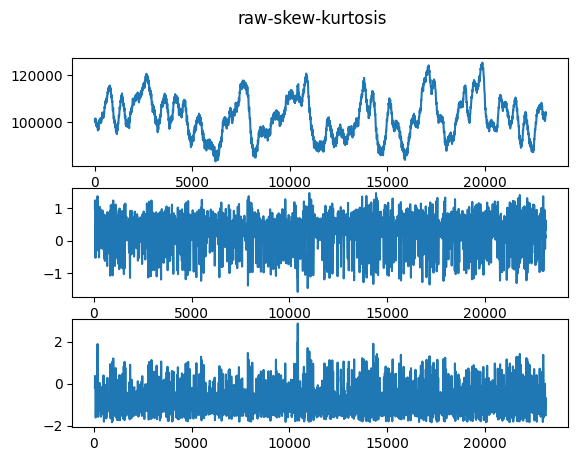

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.1303455461702841
ppg1 - kutosis -0.7306785630216841


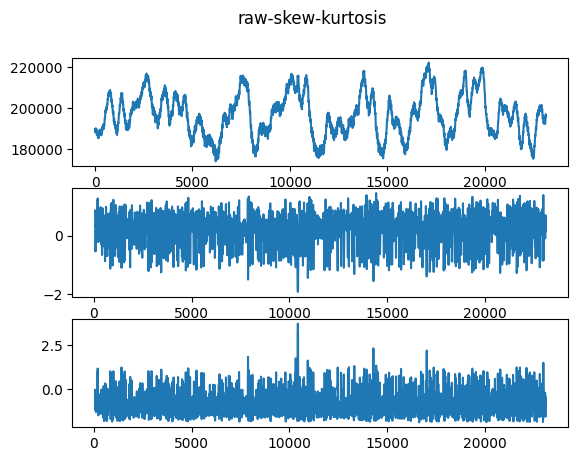

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.11760567837961407
ppg2 - kutosis -0.5651382444949484


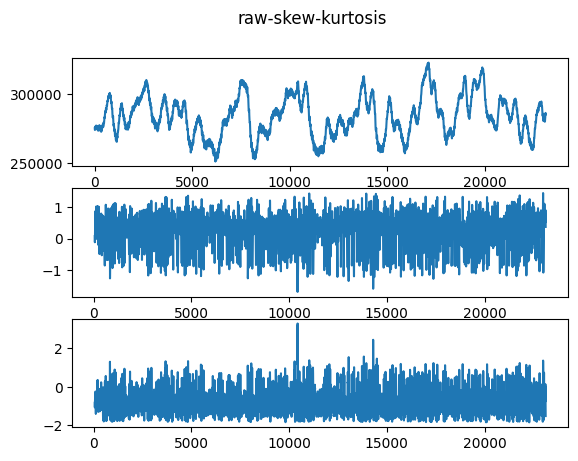

<Figure size 1200x800 with 0 Axes>

(H)002_20230429_102726_Verity.csv
인덱스 길이: 22400
ppg0 - skew 0.26692821689844914
ppg0 - kutosis 0.9368289024623113


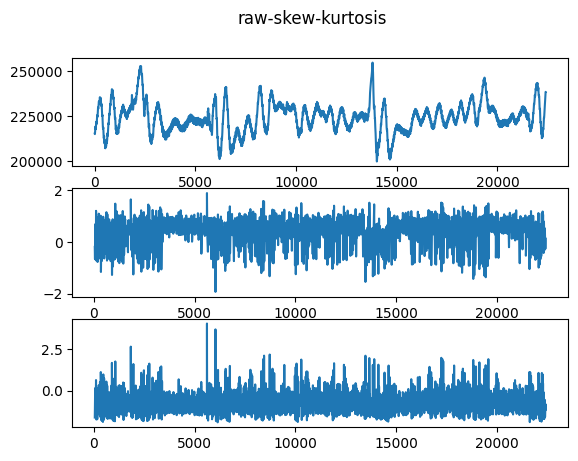

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.5274887124476276
ppg1 - kutosis 1.7384987630477609


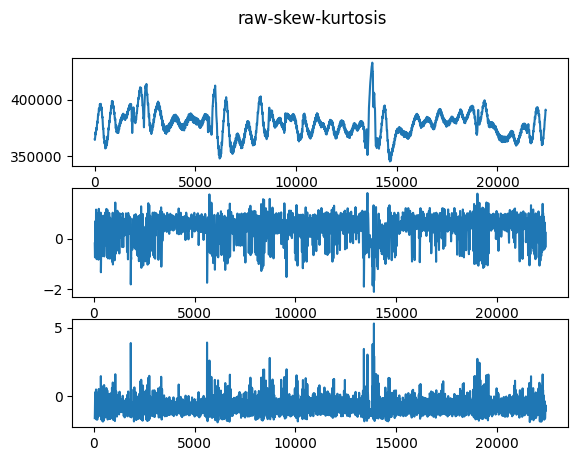

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.02508515037878008
ppg2 - kutosis 0.8530606895917581


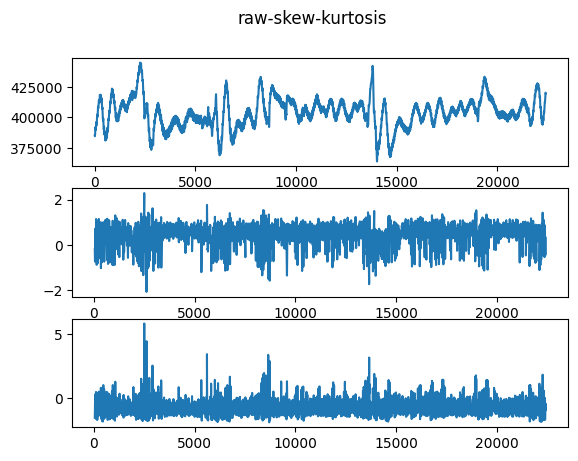

<Figure size 1200x800 with 0 Axes>

(H)003_20230429_105826_Verity.csv
인덱스 길이: 23153
ppg0 - skew -0.008632076096110388
ppg0 - kutosis -0.12806165875078124


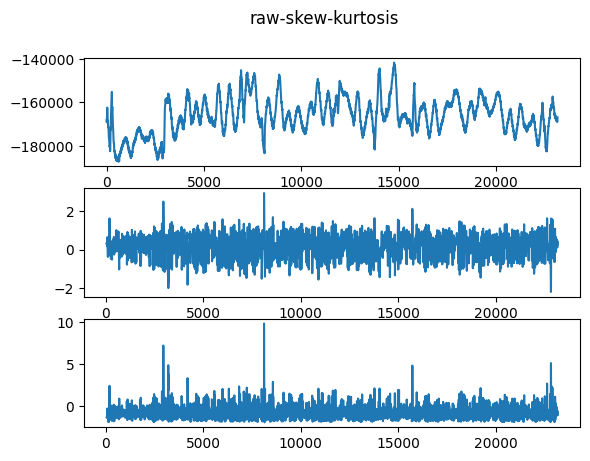

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.5544818992279033
ppg1 - kutosis 0.36529498245980063


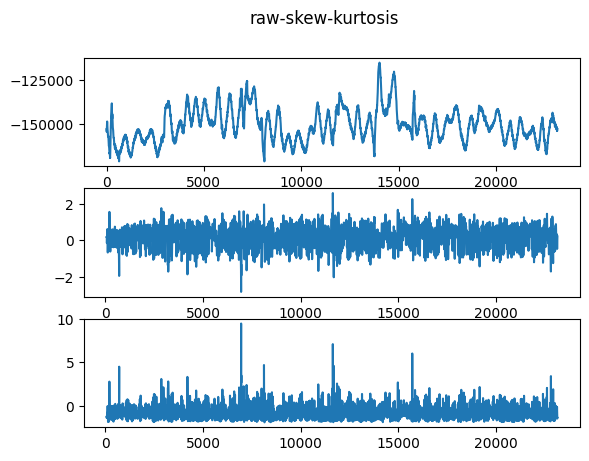

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.23193919570619645
ppg2 - kutosis -0.3967744680378802


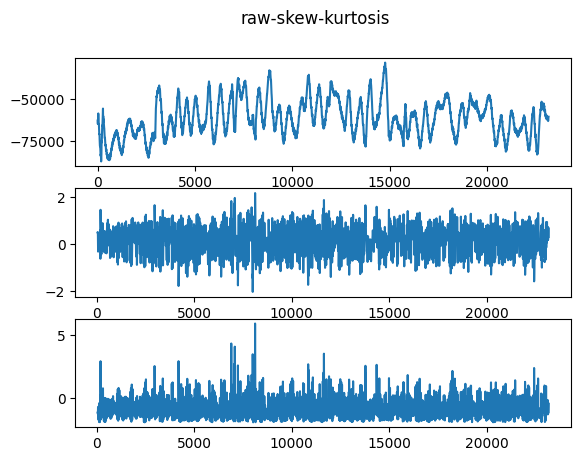

<Figure size 1200x800 with 0 Axes>

(H)004_20230429_100701_Verity.csv
인덱스 길이: 22048
ppg0 - skew 7.3156207661426045
ppg0 - kutosis 68.58563083053428


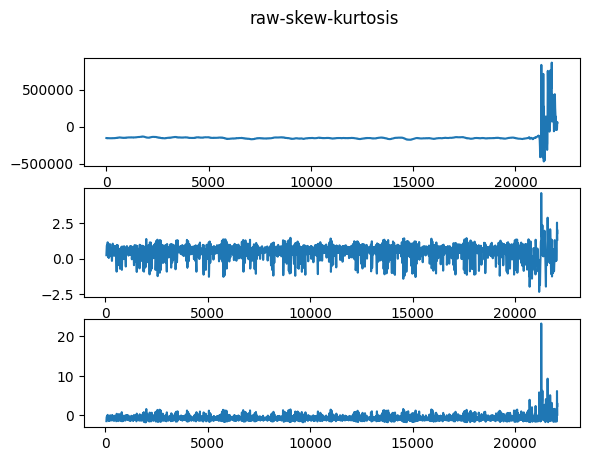

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 7.689319578597345
ppg1 - kutosis 75.50487933295842


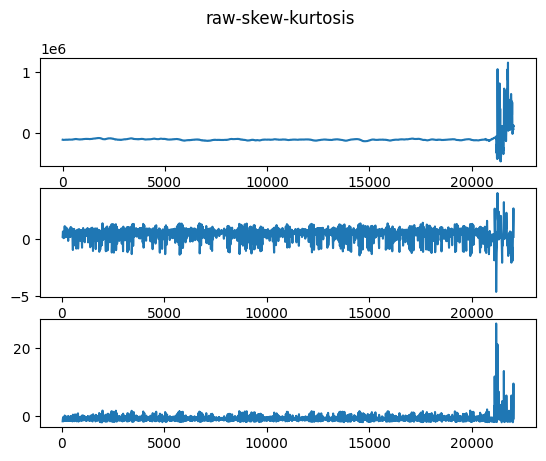

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 7.0679884387403815
ppg2 - kutosis 73.04681321926856


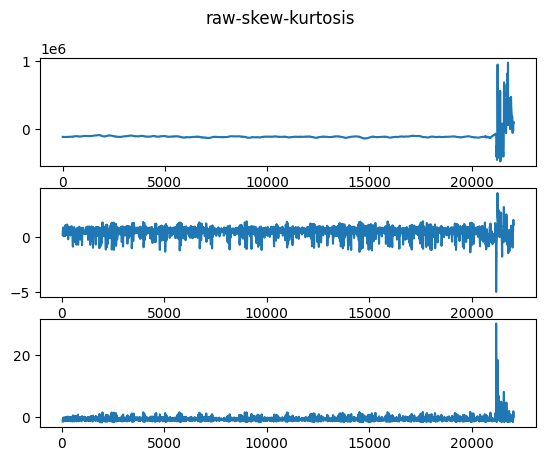

<Figure size 1200x800 with 0 Axes>

(H)005_20230429_120717_Verity.csv
인덱스 길이: 23042
ppg0 - skew 0.2440184768471379
ppg0 - kutosis -0.6330201435294454


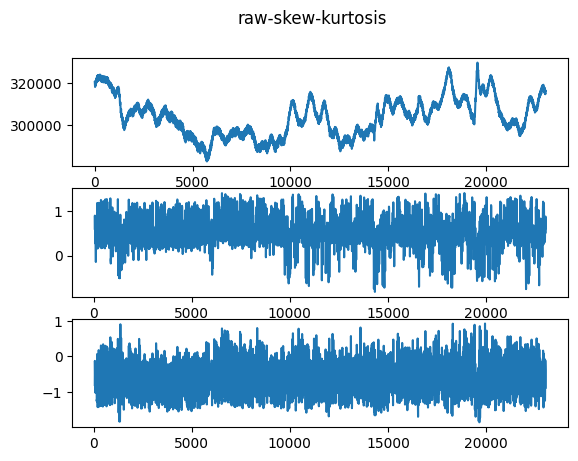

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.31842634987820284
ppg1 - kutosis -0.4583933471378909


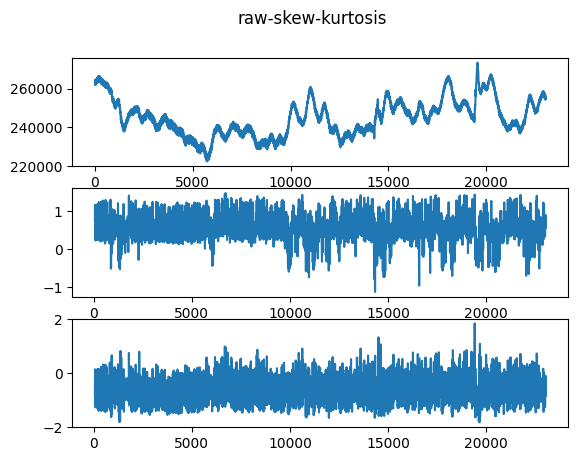

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.47120867057756255
ppg2 - kutosis -0.32182853835114855


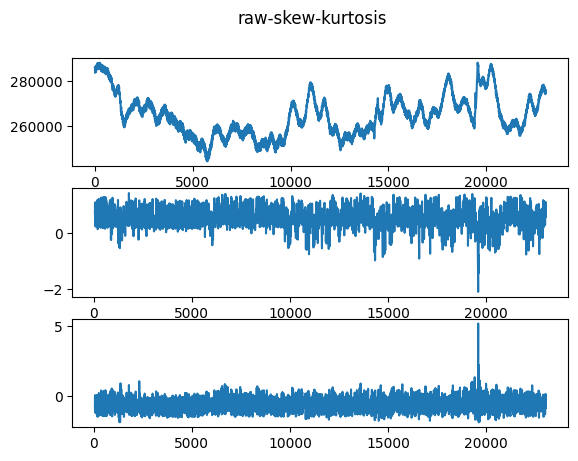

<Figure size 1200x800 with 0 Axes>

(H)006_20230429_115029_Verity.csv
인덱스 길이: 23382
ppg0 - skew 0.3550142141480826
ppg0 - kutosis -0.2217773816772315


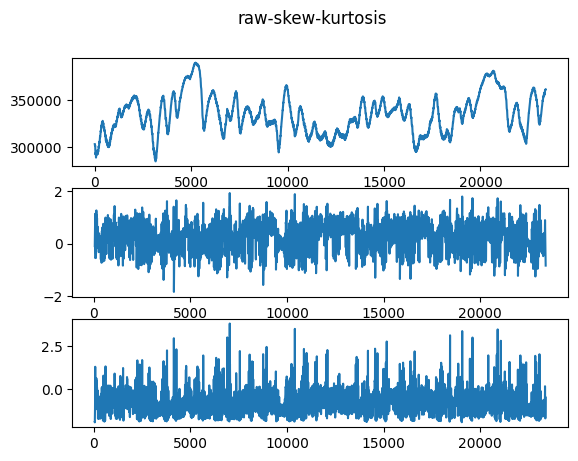

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.2525831840794202
ppg1 - kutosis -0.34310746816135795


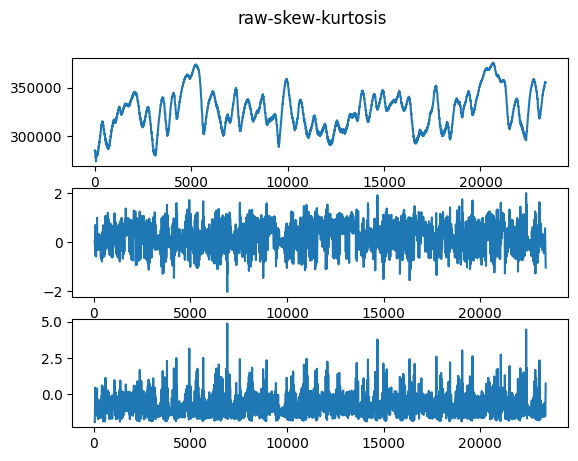

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.20673983093635476
ppg2 - kutosis -0.23251582829278483


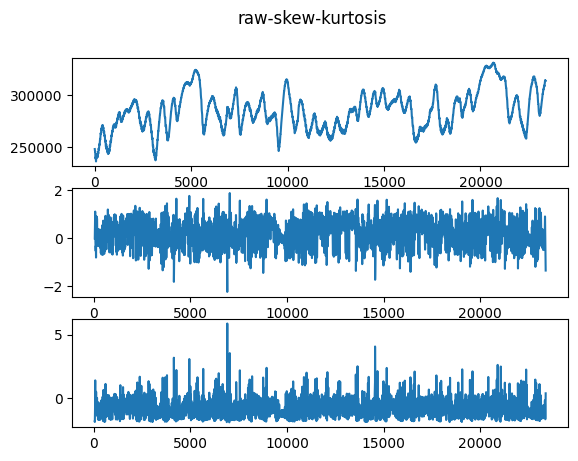

<Figure size 1200x800 with 0 Axes>

(H)007_20230429_115342_Verity.csv
인덱스 길이: 22693
ppg0 - skew 1.6636429492170415
ppg0 - kutosis 5.625115228929637


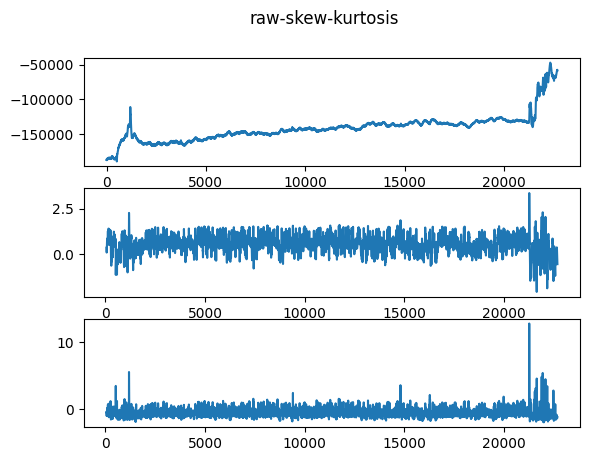

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 1.4353296459962557
ppg1 - kutosis 5.635364030126276


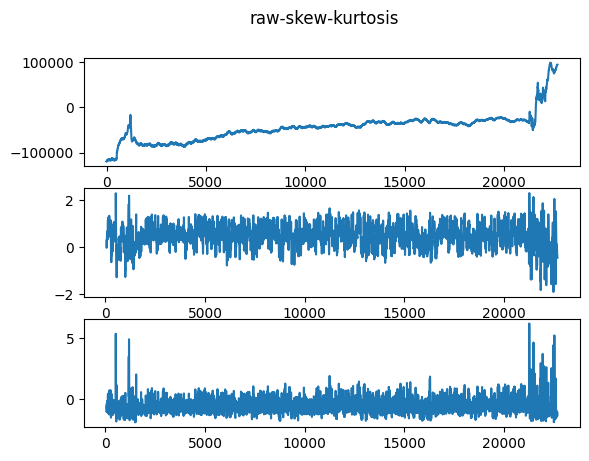

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.5965135231502617
ppg2 - kutosis 2.608558863281721


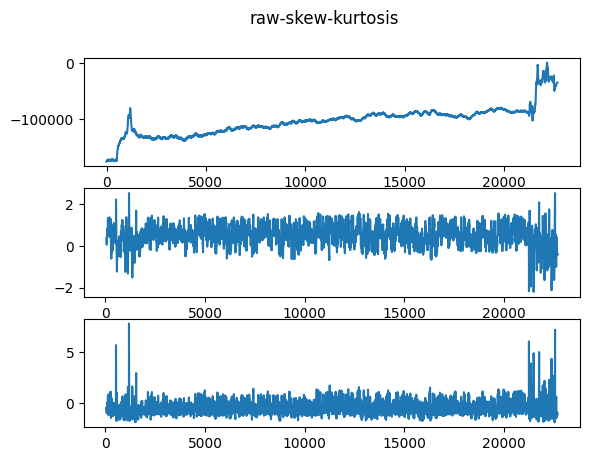

<Figure size 1200x800 with 0 Axes>

(H)008_20230429_111204_Verity.csv
인덱스 길이: 23765
ppg0 - skew 0.3317193021979185
ppg0 - kutosis -0.6529123311002922


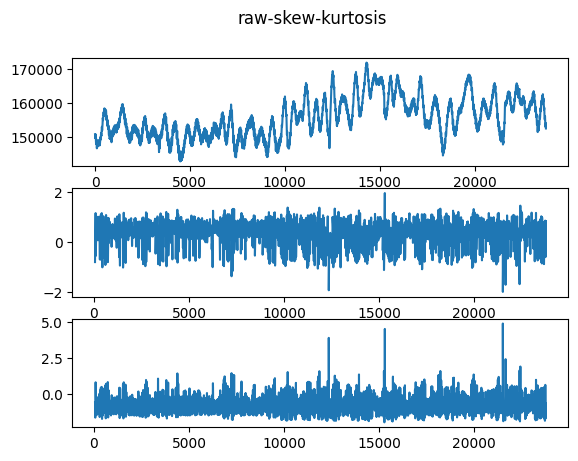

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.33983266035789905
ppg1 - kutosis -0.7073415160287624


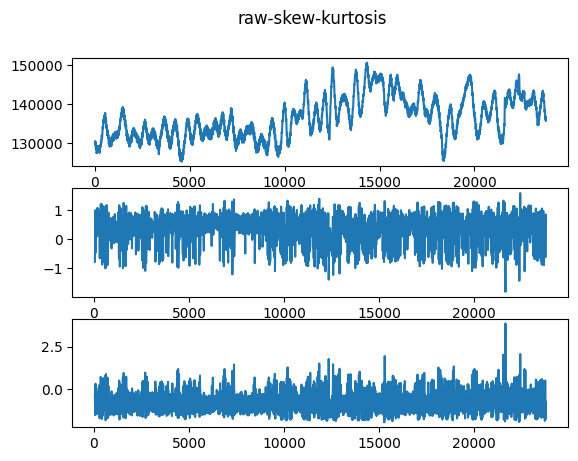

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.4011831355823639
ppg2 - kutosis -0.4855312719151841


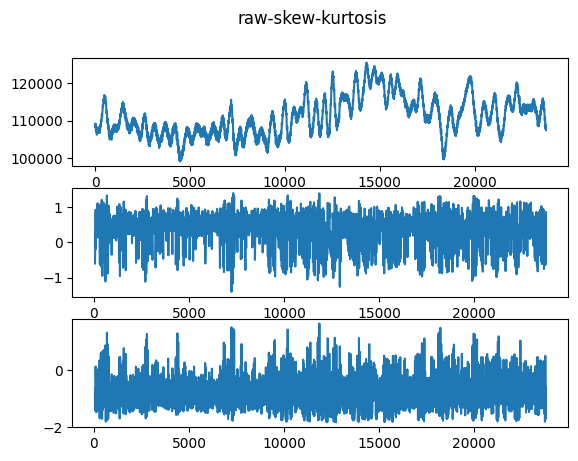

<Figure size 1200x800 with 0 Axes>

(H)009_20230429_112014_Verity.csv
인덱스 길이: 23069
ppg0 - skew 0.5105683819808431
ppg0 - kutosis 0.02655892184524289


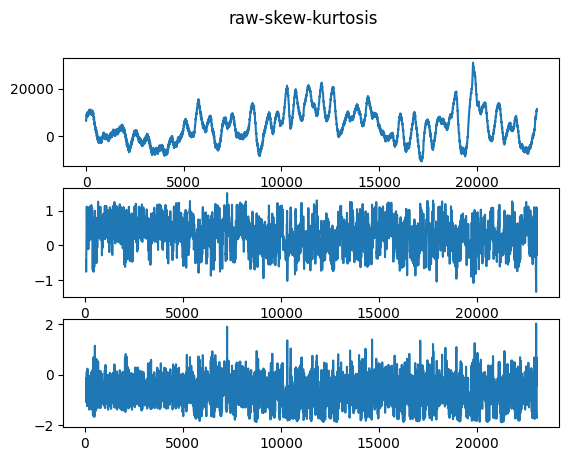

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.5977953389960997
ppg1 - kutosis 0.10174234480116251


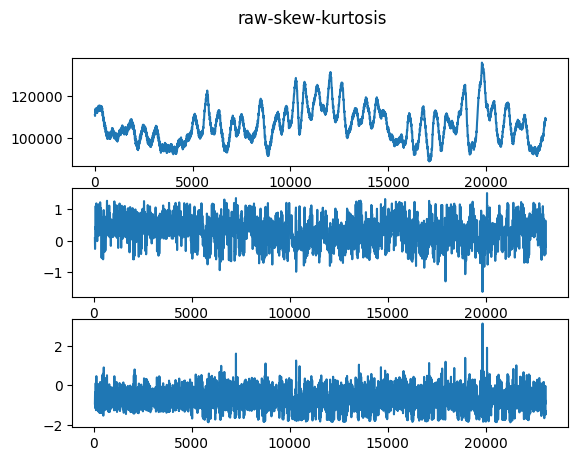

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.4882003558093573
ppg2 - kutosis 0.2308138906799404


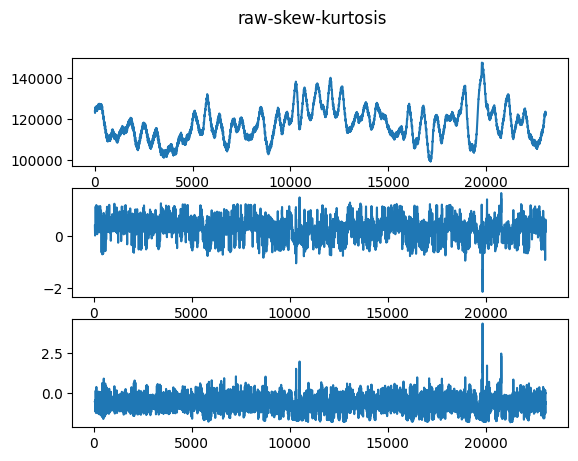

<Figure size 1200x800 with 0 Axes>

(H)010_20230429_114546_Verity.csv
인덱스 길이: 22889
ppg0 - skew 1.0337669182371234
ppg0 - kutosis 1.116330106345826


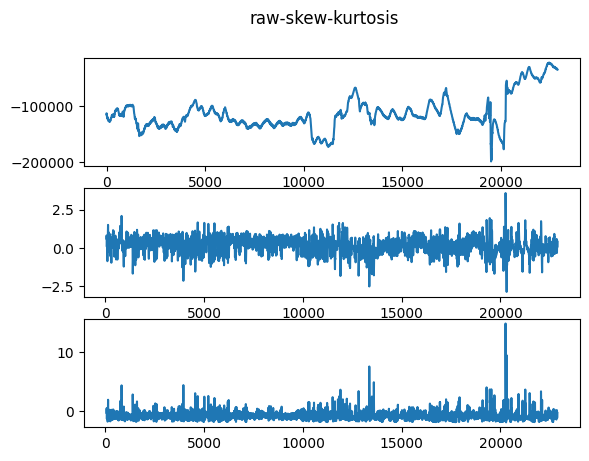

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 1.5625255277484253
ppg1 - kutosis 2.442398329194207


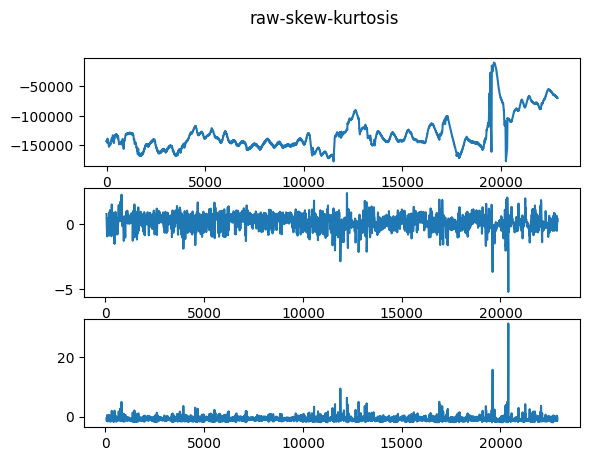

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.6349433343355819
ppg2 - kutosis 0.2653537186510997


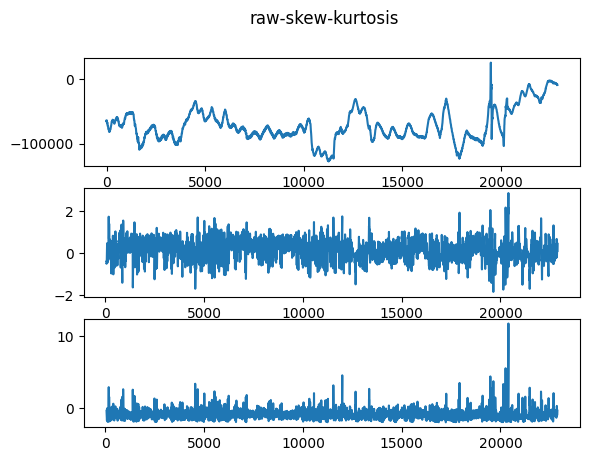

<Figure size 1200x800 with 0 Axes>

(H)011_20230429_122611_Verity.csv
인덱스 길이: 22985
ppg0 - skew 1.355848188313731
ppg0 - kutosis 2.572701645227247


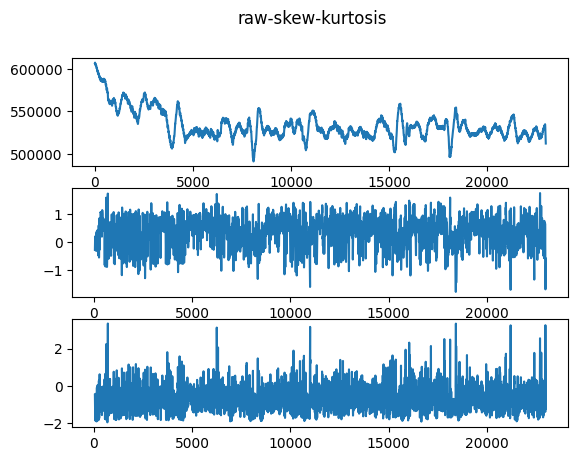

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 1.5112539224303914
ppg1 - kutosis 2.764251199863158


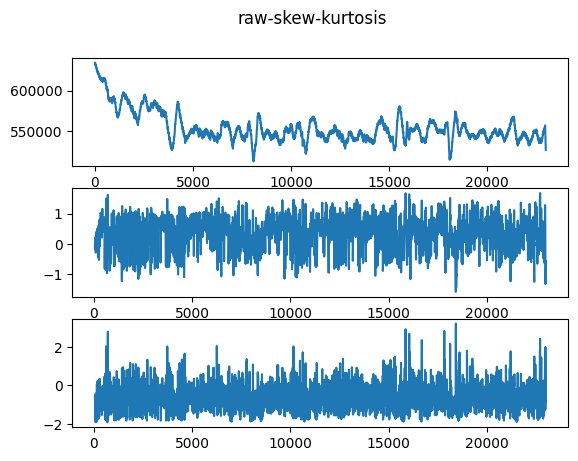

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 1.4079385813554204
ppg2 - kutosis 2.7223185731229274


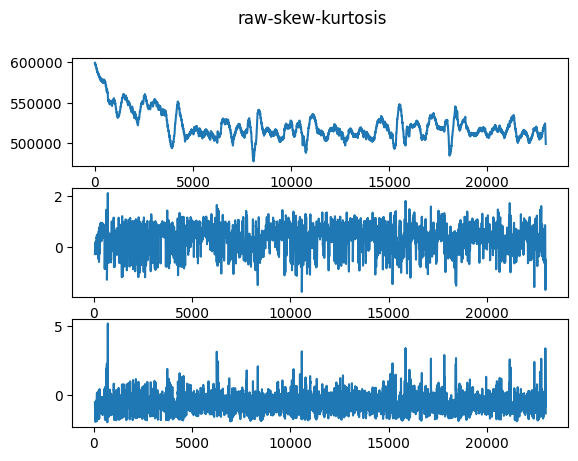

<Figure size 1200x800 with 0 Axes>

(H)012_20230429_091307_Verity.csv
인덱스 길이: 24479
ppg0 - skew 16.286521313027865
ppg0 - kutosis 476.9314180576681


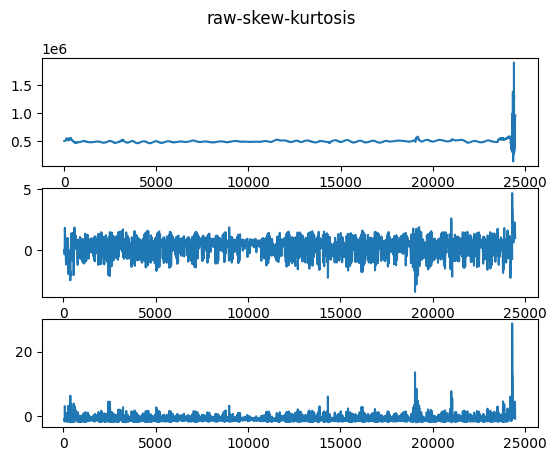

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 7.963244680644434
ppg1 - kutosis 232.9230314789685


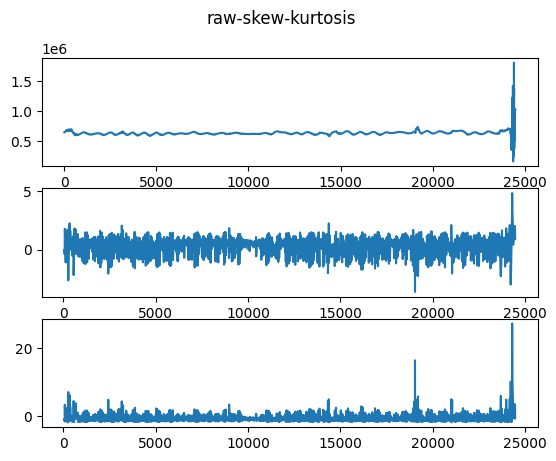

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 14.426334706769016
ppg2 - kutosis 468.9881361889042


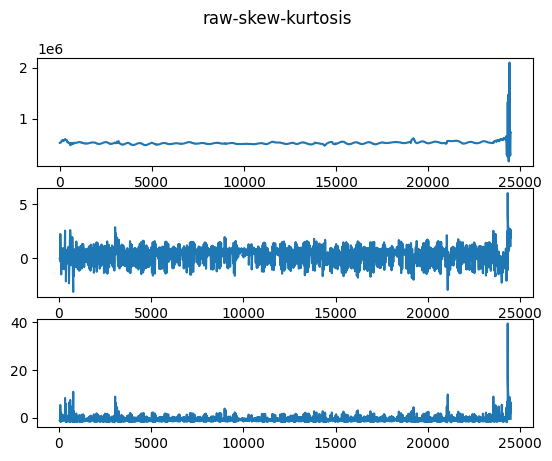

<Figure size 1200x800 with 0 Axes>

(H)013_20230429_130300_Verity.csv
인덱스 길이: 25529
ppg0 - skew 0.8080654360511899
ppg0 - kutosis 1.4992756804352396


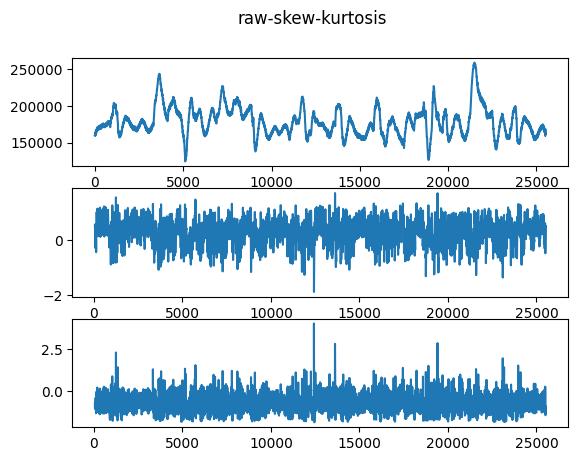

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.6143638272676866
ppg1 - kutosis 1.0790422122339125


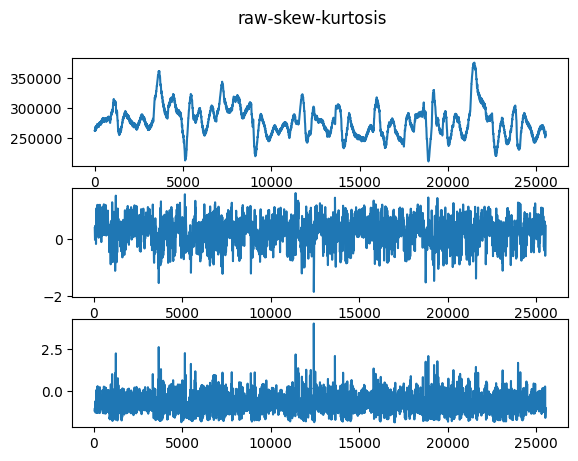

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.683233635012019
ppg2 - kutosis 0.95832472557646


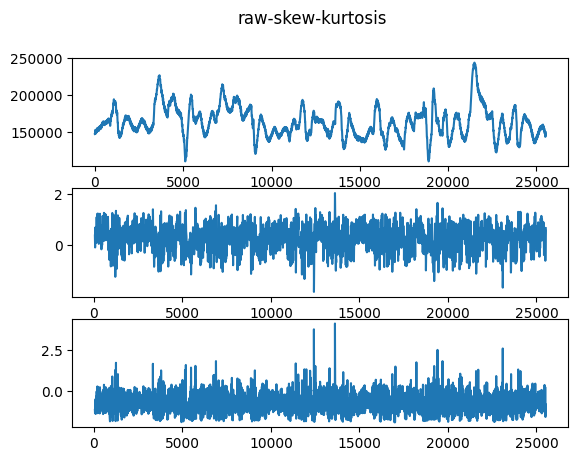

<Figure size 1200x800 with 0 Axes>

(H)014_20230429_125958_Verity.csv
인덱스 길이: 39845
ppg0 - skew 0.6603390023476684
ppg0 - kutosis 0.3032511775316622


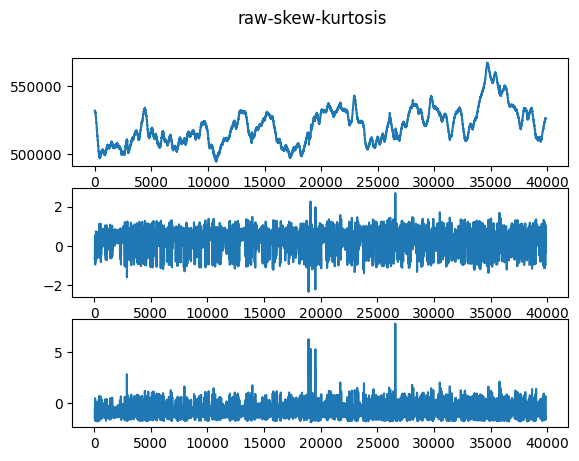

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.6967177933241848
ppg1 - kutosis 0.2822582542648946


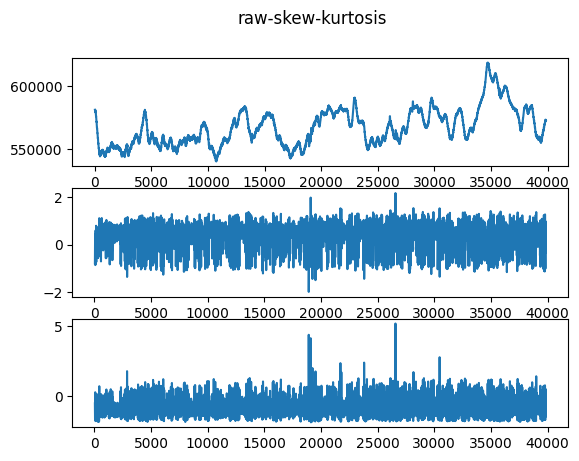

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.6764477343752109
ppg2 - kutosis 0.20006664282694553


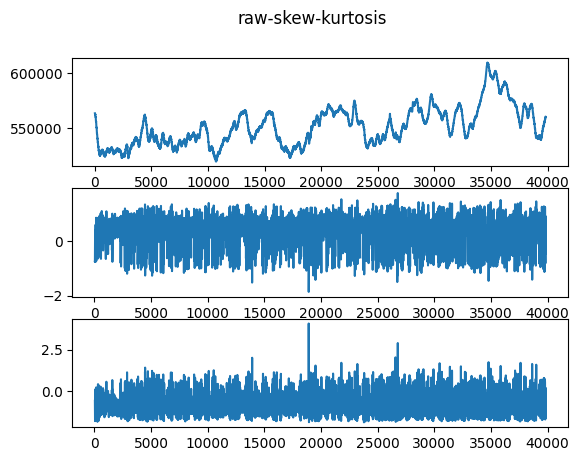

<Figure size 1200x800 with 0 Axes>

(H)016_20230429_094329_Verity.csv
인덱스 길이: 23054
ppg0 - skew 0.04355757927391189
ppg0 - kutosis 0.17984356861796913


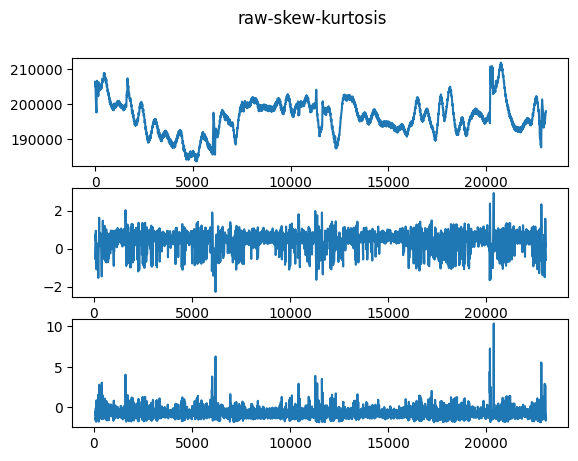

<Figure size 1200x800 with 0 Axes>

ppg1 - skew -0.4966134707153289
ppg1 - kutosis 0.46659986812526055


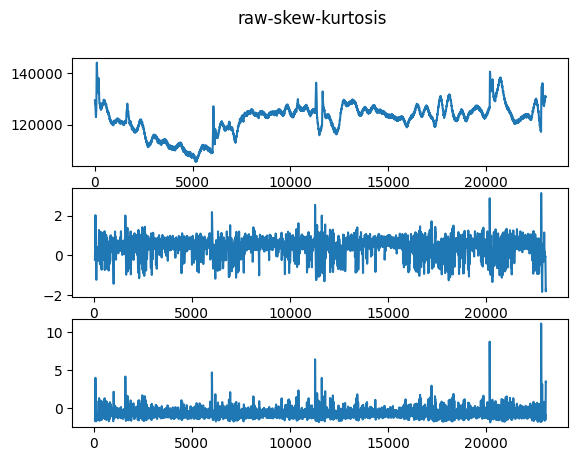

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.19643058484103426
ppg2 - kutosis 0.25523173093673224


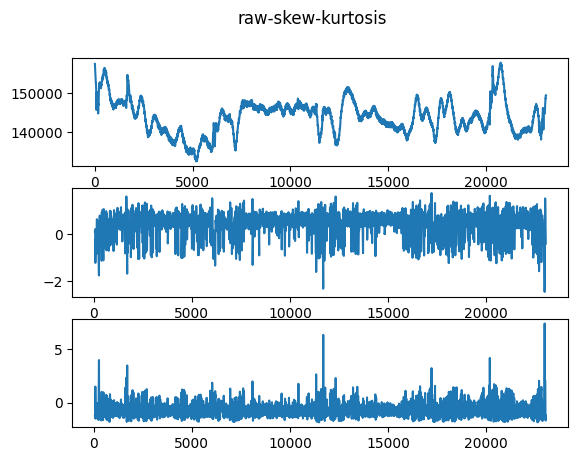

<Figure size 1200x800 with 0 Axes>

(H)017_20230429_122613_Verity.csv
인덱스 길이: 19223
ppg0 - skew 0.9077142124428393
ppg0 - kutosis 0.5011909857963017


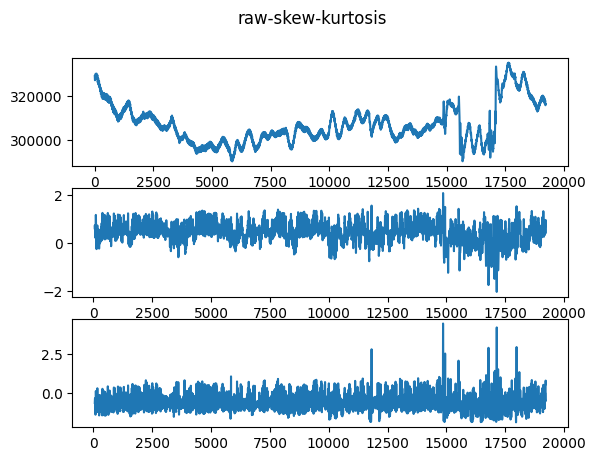

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.09230439466758032
ppg1 - kutosis -0.23096016645766948


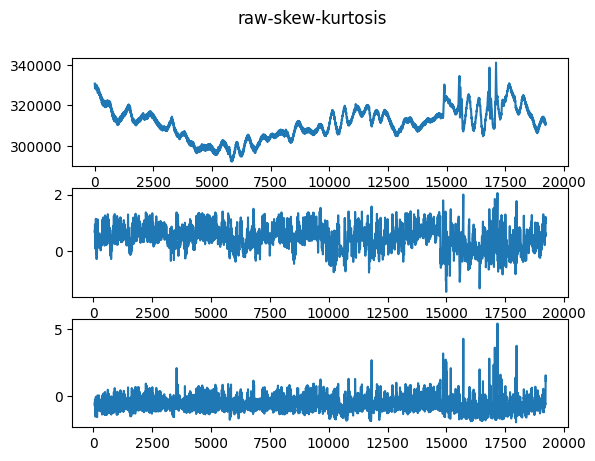

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.8225391076815066
ppg2 - kutosis 0.7866433095147984


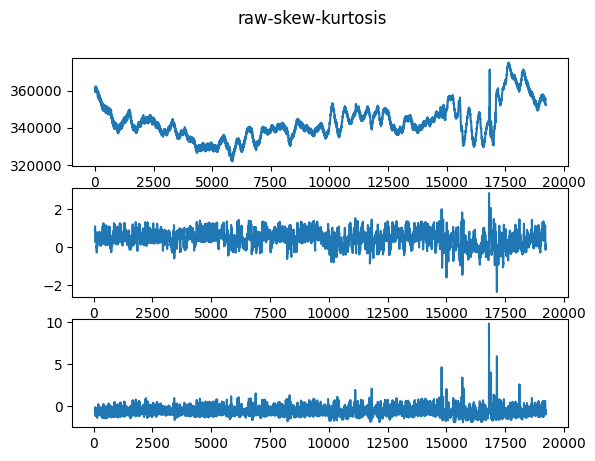

<Figure size 1200x800 with 0 Axes>

(H)018_20230429_123305_Verity.csv
인덱스 길이: 23099
ppg0 - skew 2.1987838927724885
ppg0 - kutosis 9.733125284351061


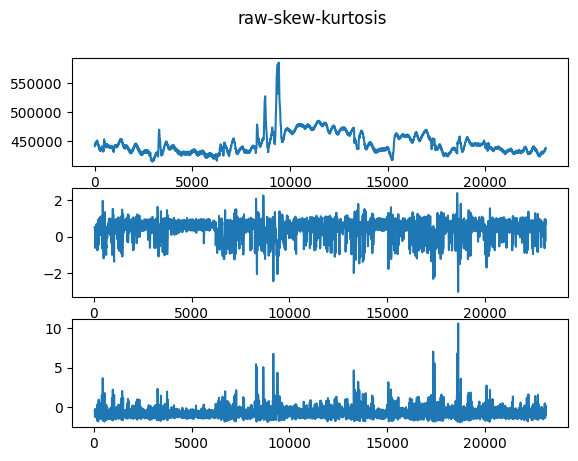

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 3.3428073001592185
ppg1 - kutosis 22.439650349875457


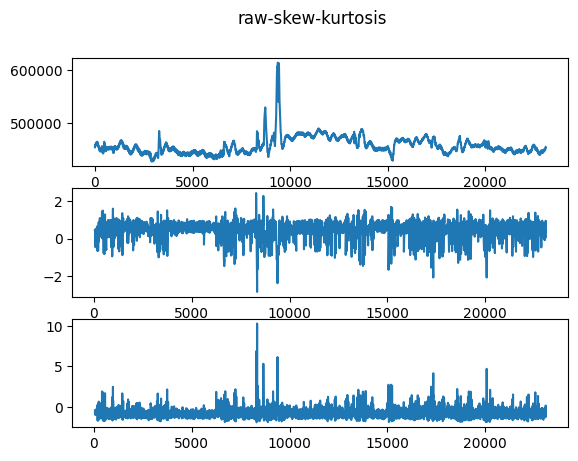

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 2.2815160077693495
ppg2 - kutosis 11.706576061620432


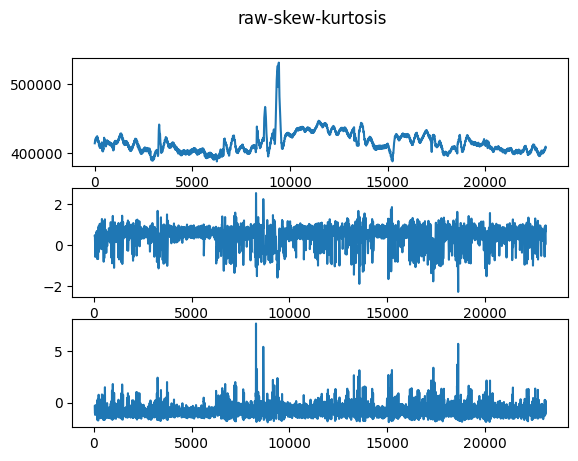

<Figure size 1200x800 with 0 Axes>

(H)019_20230429_102909_Verity.csv
인덱스 길이: 23072
ppg0 - skew 0.10824318634044676
ppg0 - kutosis 0.6727213414022897


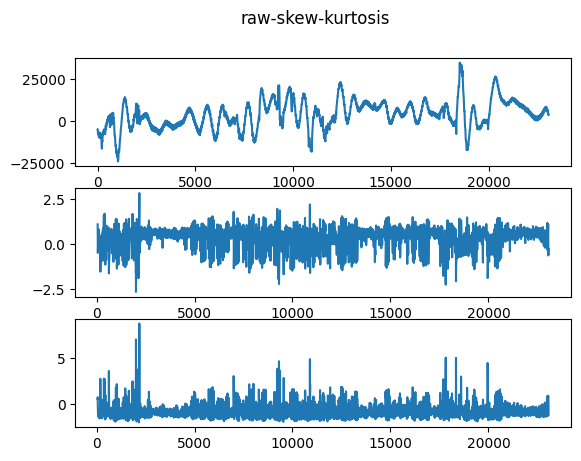

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 0.0637525115076102
ppg1 - kutosis 0.2862770904165295


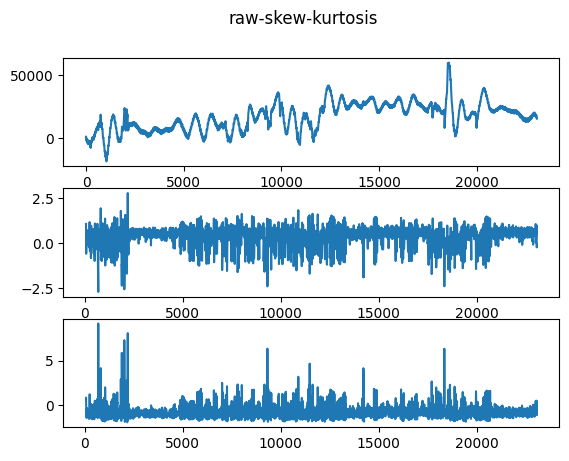

<Figure size 1200x800 with 0 Axes>

ppg2 - skew -0.18424042502808988
ppg2 - kutosis 0.5233918316025563


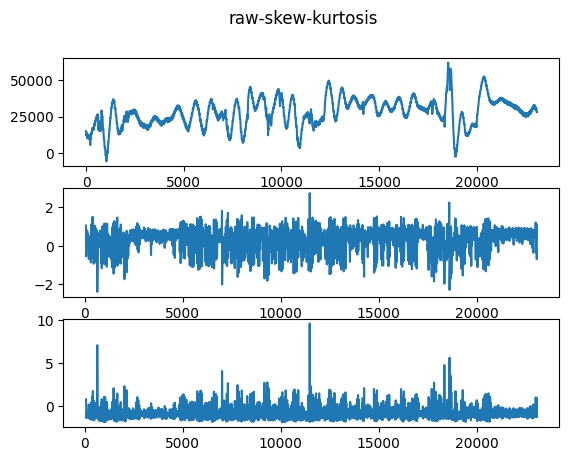

<Figure size 1200x800 with 0 Axes>

(H)020_20230429_131738_Verity.csv
인덱스 길이: 23183
ppg0 - skew 2.426342409462694
ppg0 - kutosis 20.211838481056784


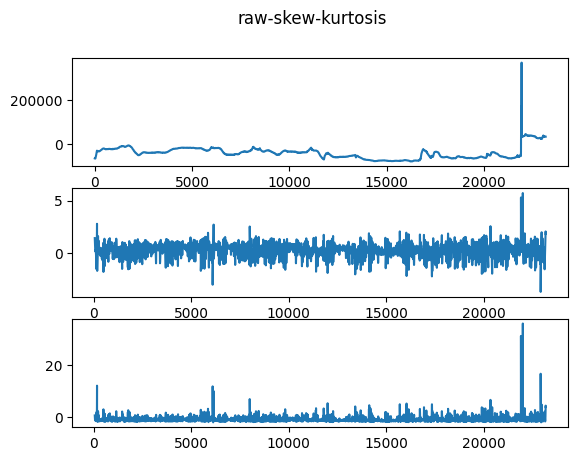

<Figure size 1200x800 with 0 Axes>

ppg1 - skew 3.1391229335752175
ppg1 - kutosis 40.16182751998202


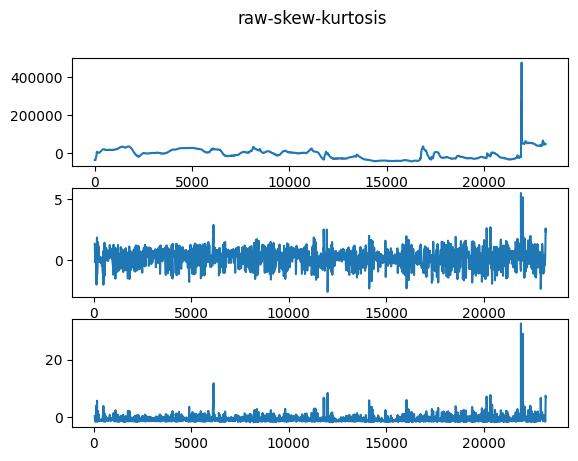

<Figure size 1200x800 with 0 Axes>

ppg2 - skew 0.7962286525333936
ppg2 - kutosis 6.476071000152389


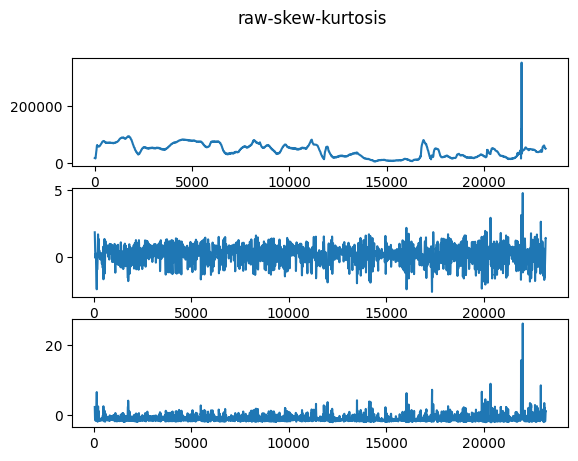

<Figure size 1200x800 with 0 Axes>

In [12]:
import padasip as pa
# https://matousc89.github.io/padasip/sources/filters/lms.html

for i in resting_verity_dict:
    print(i)
    print('인덱스 길이:',len(resting_verity_dict[i]))
    signals = resting_verity_dict[i][['ppg0', 'ppg1', 'ppg2']]
    ambient = resting_verity_dict[i]['ambient']

    for j in signals:
        print(j, '- skew', scipy.stats.skew(signals[j]))
        print(j, '- kutosis', scipy.stats.kurtosis(signals[j]))
        fig, axs = plt.subplots(3)
        fig.suptitle('raw-skew-kurtosis')
        plt.figure(figsize=(15, 10), dpi=80)

        axs[1].plot(pd.DataFrame(signals[j]).rolling(window = 55).skew())
        axs[2].plot(pd.DataFrame(signals[j]).rolling(window = 55).kurt())
        axs[0].plot(signals[j])
        plt.show()
        

피험자 수: 19 명
(H)001_20230429_091641_Verity.csv
인덱스 길이: 23129


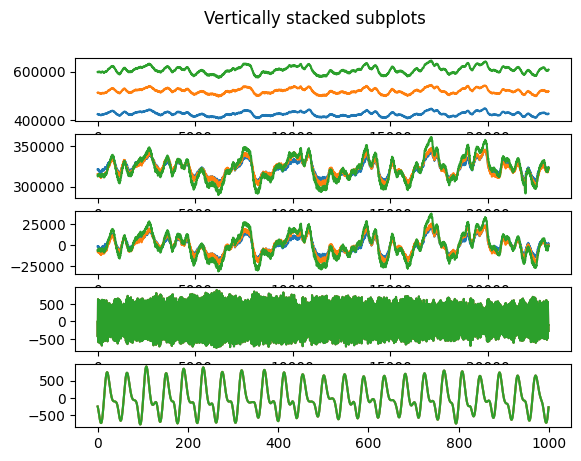

<Figure size 1200x800 with 0 Axes>

(H)002_20230429_102726_Verity.csv
인덱스 길이: 22400


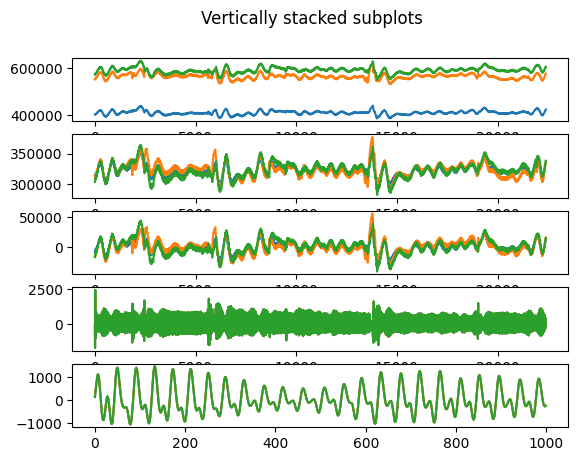

<Figure size 1200x800 with 0 Axes>

(H)003_20230429_105826_Verity.csv
인덱스 길이: 23153


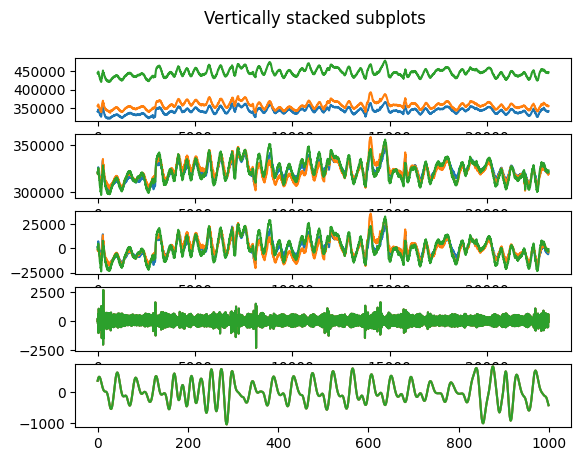

<Figure size 1200x800 with 0 Axes>

(H)004_20230429_100701_Verity.csv
인덱스 길이: 22048


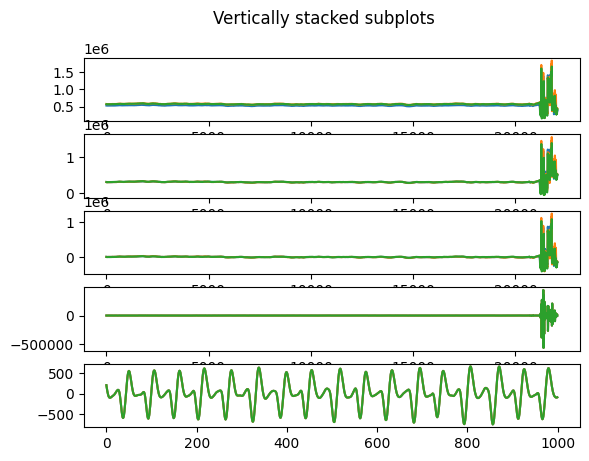

<Figure size 1200x800 with 0 Axes>

(H)005_20230429_120717_Verity.csv
인덱스 길이: 23042


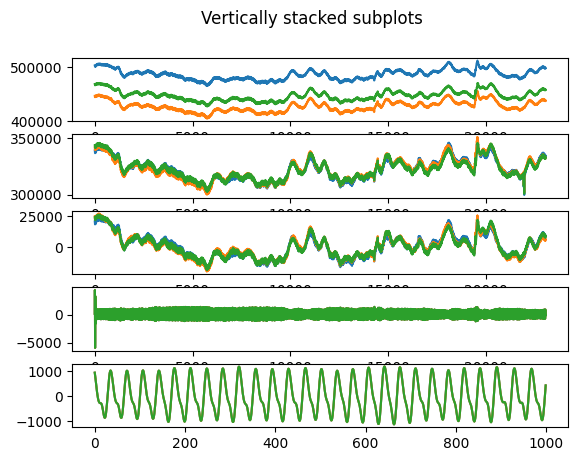

<Figure size 1200x800 with 0 Axes>

(H)006_20230429_115029_Verity.csv
인덱스 길이: 23382


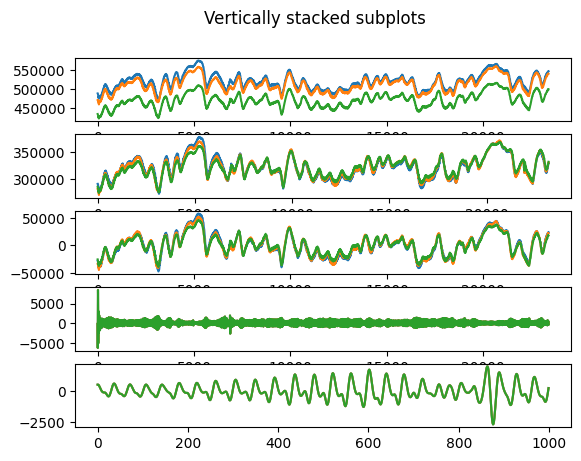

<Figure size 1200x800 with 0 Axes>

(H)007_20230429_115342_Verity.csv
인덱스 길이: 22693


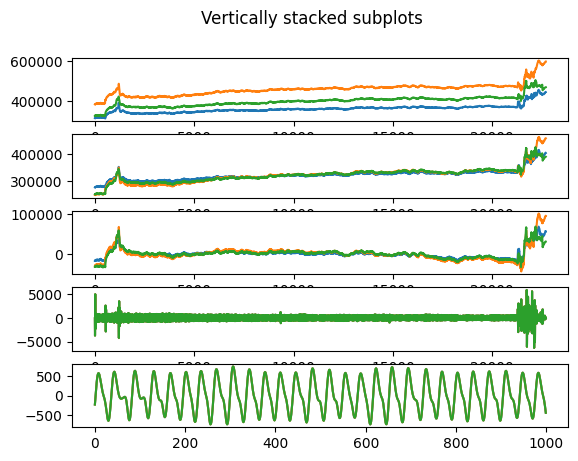

<Figure size 1200x800 with 0 Axes>

(H)008_20230429_111204_Verity.csv
인덱스 길이: 23765


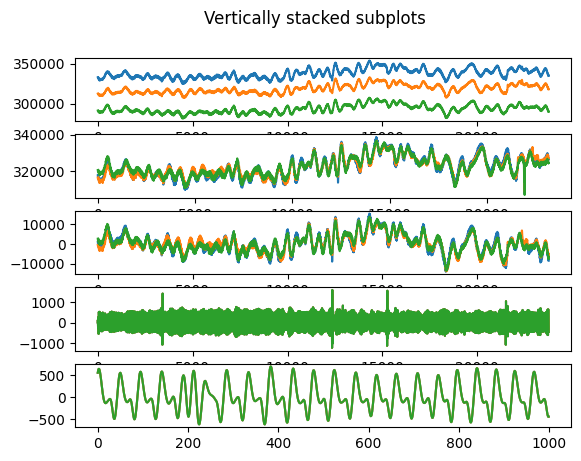

<Figure size 1200x800 with 0 Axes>

(H)009_20230429_112014_Verity.csv
인덱스 길이: 23069


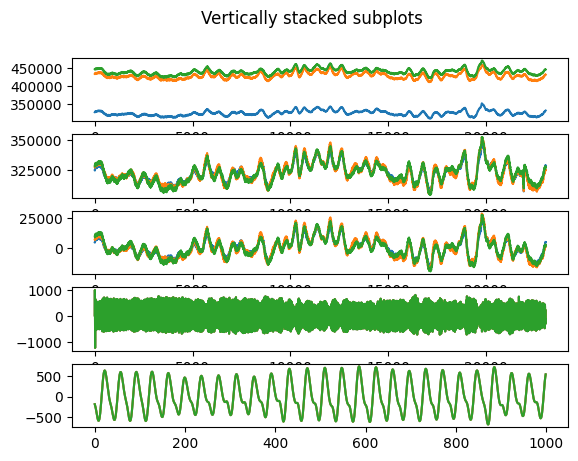

<Figure size 1200x800 with 0 Axes>

(H)010_20230429_114546_Verity.csv
인덱스 길이: 22889


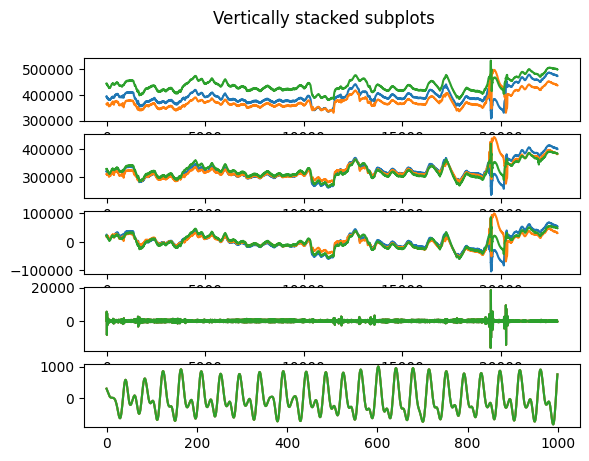

<Figure size 1200x800 with 0 Axes>

(H)011_20230429_122611_Verity.csv
인덱스 길이: 22985


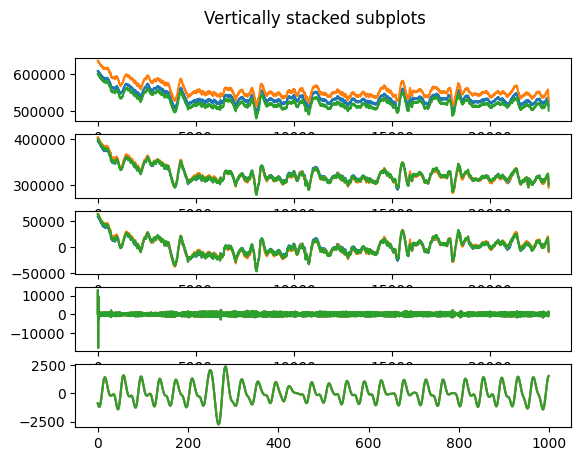

<Figure size 1200x800 with 0 Axes>

(H)012_20230429_091307_Verity.csv
인덱스 길이: 24479


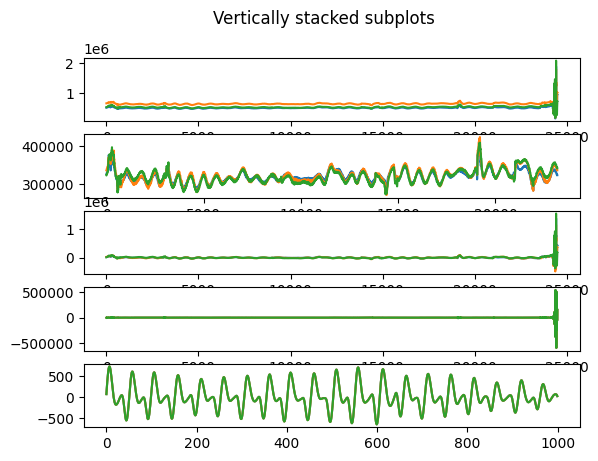

<Figure size 1200x800 with 0 Axes>

(H)013_20230429_130300_Verity.csv
인덱스 길이: 25529


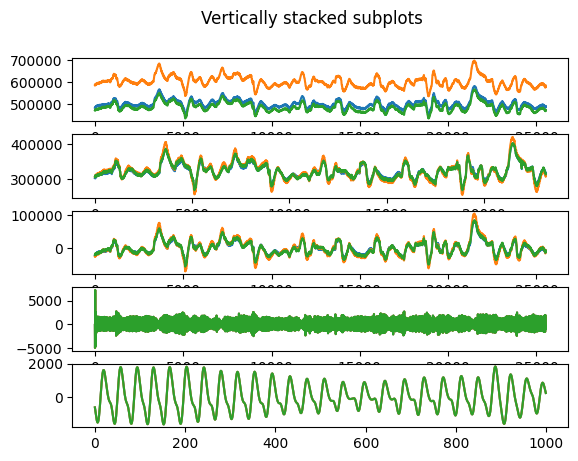

<Figure size 1200x800 with 0 Axes>

(H)014_20230429_125958_Verity.csv
인덱스 길이: 39845


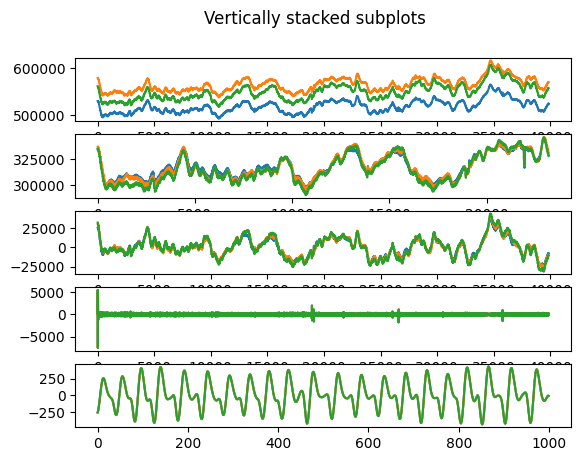

<Figure size 1200x800 with 0 Axes>

(H)016_20230429_094329_Verity.csv
인덱스 길이: 23054


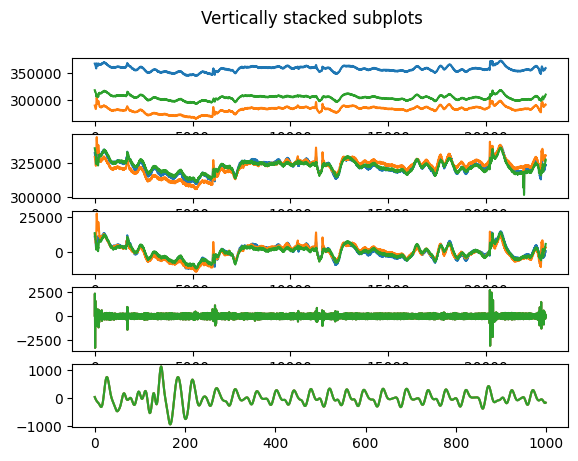

<Figure size 1200x800 with 0 Axes>

(H)017_20230429_122613_Verity.csv
인덱스 길이: 19223


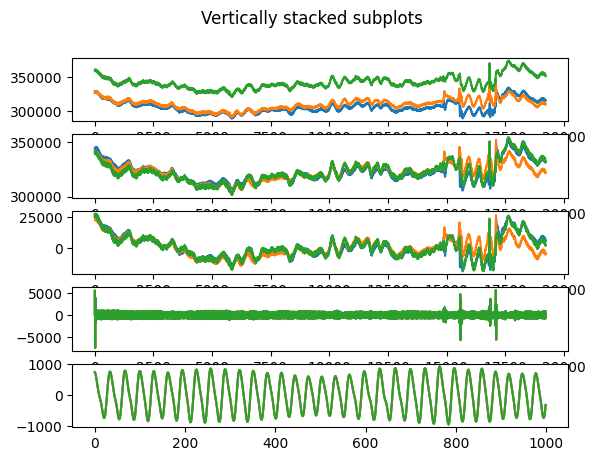

<Figure size 1200x800 with 0 Axes>

(H)018_20230429_123305_Verity.csv
인덱스 길이: 23099


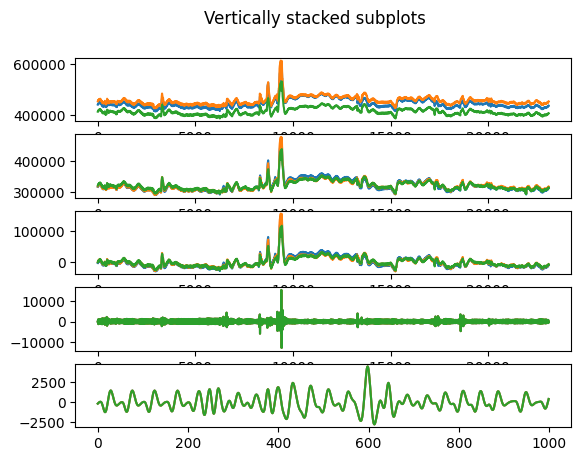

<Figure size 1200x800 with 0 Axes>

(H)019_20230429_102909_Verity.csv
인덱스 길이: 23072


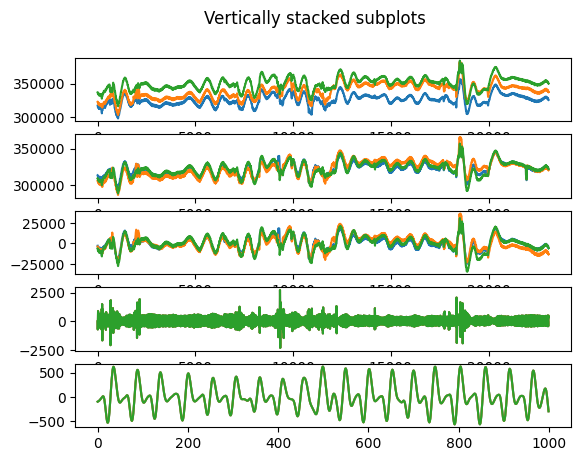

<Figure size 1200x800 with 0 Axes>

(H)020_20230429_131738_Verity.csv
인덱스 길이: 23183


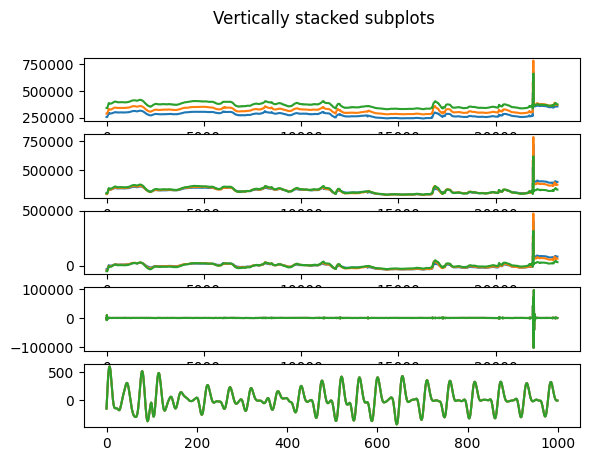

<Figure size 1200x800 with 0 Axes>

In [13]:
print('피험자 수:', len(resting_verity_dict), '명')
fs = VERITY_FS
#cutoff Wn
# cutoff = [fs*0.03,fs/2*0.97]
cutoff = [1.5,3]
ts = 1/ fs
Nyq = fs / 2
# 파라미터 계수 N
order = 2

sos = signal.butter(order, cutoff, btype='bandpass', output = 'sos', fs = fs)


for i in resting_verity_dict:
    print(i)
    print('인덱스 길이:',len(resting_verity_dict[i]))
    signals = resting_verity_dict[i][['ppg0', 'ppg1', 'ppg2', 'ambient']]

    # data resampling
    sample_rate = VERITY_FS
    resample_scale = 10
    resampled_signals = resample(signals, len(signals) * resample_scale)
    resample_length = len(resampled_signals)
    resample_rate = sample_rate * resample_scale
    
#     for j in resampled_signals:
#         #
#         resampled_signals[j]
    
    
    length = len(resting_verity_dict[i])
    f = np.linspace(-(fs / 2), fs / 2, length)

    
    # ambient = resting_verity_dict[i]['ambient'] - resting_verity_dict[i]['ambient'].mean()
    
    signal_0 = resting_verity_dict[i]['ppg0'] - resting_verity_dict[i]['ambient']
    signal_1 = resting_verity_dict[i]['ppg1'] - resting_verity_dict[i]['ambient']
    signal_2 = resting_verity_dict[i]['ppg2'] - resting_verity_dict[i]['ambient']
    
    signal_0_avdc = resting_verity_dict[i]['ppg0'] - resting_verity_dict[i]['ppg0'].mean() - ambient
    signal_1_avdc = resting_verity_dict[i]['ppg1'] - resting_verity_dict[i]['ppg1'].mean() - ambient
    signal_2_avdc = resting_verity_dict[i]['ppg2'] - resting_verity_dict[i]['ppg2'].mean() - ambient  
    
    signal_0_ffty=signal.detrend(signal_0)
    signal_1_ffty=signal.detrend(signal_1)
    signal_2_ffty=signal.detrend(signal_2)
    
    signal_0_filtered = signal.sosfilt(sos, signal_0_ffty)
    signal_1_filtered = signal.sosfilt(sos, signal_0_ffty)
    signal_2_filtered = signal.sosfilt(sos, signal_0_ffty)
    
    
    fig, axs = plt.subplots(5)
    fig.suptitle('Vertically stacked subplots')
    plt.figure(figsize=(15, 10), dpi=80)

    axs[0].plot(signal_0)
    axs[0].plot(signal_1)
    axs[0].plot(signal_2)
    
    axs[1].plot(signal_0_avdc)
    axs[1].plot(signal_1_avdc)
    axs[1].plot(signal_2_avdc)
    
    axs[2].plot(signal_0_ffty)
    axs[2].plot(signal_1_ffty)
    axs[2].plot(signal_2_ffty)
    
    axs[3].plot(signal_0_filtered)
    axs[3].plot(signal_1_filtered)
    axs[3].plot(signal_2_filtered)
    
    axs[4].plot(signal_0_filtered[6000:7000])
    axs[4].plot(signal_1_filtered[6000:7000])
    axs[4].plot(signal_2_filtered[6000:7000])
    
     for s in [[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]]:
        wd, m = hp.process(signal_0_filtered[s[0]:s[1]], sample_rate = resample_rate, 
                           high_precision=True, clean_rr=True)
        hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
        hp.plot_poincare(wd, m)
        plt.show()
        for measure in m.keys():
            print('%s: %f' %(measure, m[measure]))
    
    
    plt.show()

In [14]:
sample_rate = VERITY_FS
for i in resting_verity_dict:
    print(i)
    print('인덱스 길이:',len(resting_verity_dict[i]))
    
    signals = resting_verity_dict[i][['ppg0', 'ppg1', 'ppg2', 'ambient']]
    # signal_0 = resting_verity_dict[i]['ppg0']
    # signal_1 = resting_verity_dict[i]['ppg1']
    # signal_2 = resting_verity_dict[i]['ppg2']
    
    # data resampling
    resample_scale = 10
    resampled_signals = resample(signals, len(signals) * resample_scale)
    resample_length = len(resampled_signals)
    resample_rate = sample_rate * resample_scale
    
    for j in resampled_signals:
        #
        resampled_signals[j]
    
    signal_0_q1 = np.percentile(signal_0, 25)
    signal_0_q3 = np.percentile(signal_0, 75)
    signal_0_iqr = (signal_0_q3 - signal_0_q1)*1.5
    low0 = signal_0_q1 - signal_0_iqr
    high0 = signal_0_q3 + signal_0_iqr
    outlier_index = signal_0[(signal_0<low0) | (signal_0>high0)].index

    fig, axs = plt.subplots(2)
    fig.suptitle('Vertically stacked subplots')
    plt.figure(figsize=(15, 10), dpi=80)

    axs[0].plot(signal_0)
    print(len(outlier_index))
    signal_0.drop(outlier_index, axis = 0, inplace = True)
    print(len(signal_0))
    axs[1].plot(signal_0)
#     enhanced_signal_0 = hp.enhance_peaks(signal_0, iterations=3)
#     enhanced_signal_1 = hp.enhance_peaks(signal_1, iterations=3)
#     enhanced_signal_2 = hp.enhance_peaks(signal_2, iterations=3)
    
#     filtered_signal_0 = hp.filter_signal(signal_0, [0.05, 0.1 ], sample_rate=sample_rate, 
#                                          order=3, filtertype='bandpass')
    
# #     wd, m = hp.process(resampled, sample_rate = new_sample_rate, 
# #                        high_precision=True, clean_rr=True)

#     wd, m = hp.process(filtered_signal_0, sample_rate = sample_rate,
#                        high_precision = True, clean_rr = True)
#     hp.plotter(wd, m, figsize=(12,6))
#     hp.plot_poincare(wd, m)
#     plt.show()
#     for measure in m.keys():
#         print('%s: %f' %(measure, m[measure]))
    
#     # for s in [[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]]:
#     #     wd, m = hp.process(resampled[s[0]:s[1]], sample_rate = new_sample_rate, 
#     #                        high_precision=True, clean_rr=True)
#     #     hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
#     #     hp.plot_poincare(wd, m)
#     #     plt.show()
#     #     for measure in m.keys():
#     #         print('%s: %f' %(measure, m[measure]))
#     # plt.plot(filtered_signal_0)
# #     plt.plot(filtered_signal_0[0:int(sample_rate*60)])    
    
    plt.show()
    # filtered = hp.filtering.butter_bandpass(lowcut = 0.4, highcut = 3.7, sample_rate=55.0, order=3)

(H)001_20230429_091641_Verity.csv
인덱스 길이: 23129


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
for i in resting_verity_dict:
    print(i)
    print('인덱스 길이:',len(resting_verity_dict[i]))
    
    signal_0 = resting_verity_dict[i]['ppg0']
    signal_1 = resting_verity_dict[i]['ppg1']
    signal_2 = resting_verity_dict[i]['ppg2']
    
    # enhanced_signal_0 = hp.enhance_peaks(signal_0, iterations=2)
    # enhanced_signal_1 = hp.enhance_peaks(signal_1, iterations=2)
    # enhanced_signal_2 = hp.enhance_peaks(signal_2, iterations=2)
    
    filtered_signal_0 = hp.filter_signal(signal_0, [1.5, 3.5], sample_rate=VERITY_FS, 
                                         order=2, filtertype='bandpass')
    
    resampled = resample(filtered_signal_0, len(filtered_signal_0) * 10)

    #don't forget to compute the new sampling rate
    new_sample_rate = sample_rate * 10
    
    for s in [[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]]:
        wd, m = hp.process(resampled[s[0]:s[1]], sample_rate = new_sample_rate, 
                           high_precision=True, clean_rr=True)
        hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
        hp.plot_poincare(wd, m)
        plt.show()
        for measure in m.keys():
            print('%s: %f' %(measure, m[measure]))